In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [6]:
# Конфигурация обучения
class Config:
    batch_size = 128
    epochs = 25
    lr = 0.001
    gamma = 0.7
    seed = 42
    log_interval = 200

# Инициализация устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Преобразования данных с аугментацией
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


Используемое устройство: cuda


In [8]:
#Загрузка данных
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # Добавлено определение

trainloader = torch.utils.data.DataLoader(trainset, batch_size=Config.batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Config.batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [9]:

# Архитектура модели с улучшениями
class AdvancedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Инициализация модели
model = AdvancedCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=Config.lr, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=Config.gamma)
criterion = nn.CrossEntropyLoss()



In [10]:
# Обучение с валидацией
best_acc = 0.0
train_losses, val_accs = [], []

for epoch in range(1, Config.epochs + 1):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}/{Config.epochs}', leave=False)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    val_accs.append(epoch_acc)
    
    print(f'Epoch {epoch}: Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.2f}%')
    
    # Сохранение лучшей модели
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'best_cifar_model.pth')
    
    scheduler.step()



Epoch 1: Loss: 1.2892, Val Acc: 61.92%


Epoch 2: Loss: 0.9227, Val Acc: 69.67%


Epoch 3: Loss: 0.8020, Val Acc: 74.38%


Epoch 4: Loss: 0.7337, Val Acc: 74.71%


Epoch 5: Loss: 0.6777, Val Acc: 77.65%


Epoch 6: Loss: 0.6392, Val Acc: 75.75%


Epoch 7: Loss: 0.6124, Val Acc: 81.21%


Epoch 8: Loss: 0.5540, Val Acc: 83.18%


Epoch 9: Loss: 0.5338, Val Acc: 82.67%


Epoch 10: Loss: 0.5083, Val Acc: 83.01%


Epoch 11: Loss: 0.4993, Val Acc: 83.77%


Epoch 12: Loss: 0.4849, Val Acc: 84.31%


Epoch 13: Loss: 0.4707, Val Acc: 85.22%


Epoch 14: Loss: 0.4580, Val Acc: 85.49%


Epoch 15: Loss: 0.4184, Val Acc: 85.16%


Epoch 16: Loss: 0.4121, Val Acc: 85.67%


Epoch 17: Loss: 0.3948, Val Acc: 85.81%


Epoch 18: Loss: 0.3918, Val Acc: 86.31%


Epoch 19: Loss: 0.3834, Val Acc: 86.15%


Epoch 20: Loss: 0.3739, Val Acc: 86.56%


Epoch 21: Loss: 0.3692, Val Acc: 86.27%


Epoch 22: Loss: 0.3507, Val Acc: 87.15%


Epoch 23: Loss: 0.3411, Val Acc: 87.20%


Epoch 24: Loss: 0.3337, Val Acc: 87.48%


Epoch 25: Loss: 0.3304, Val Acc: 87.65%


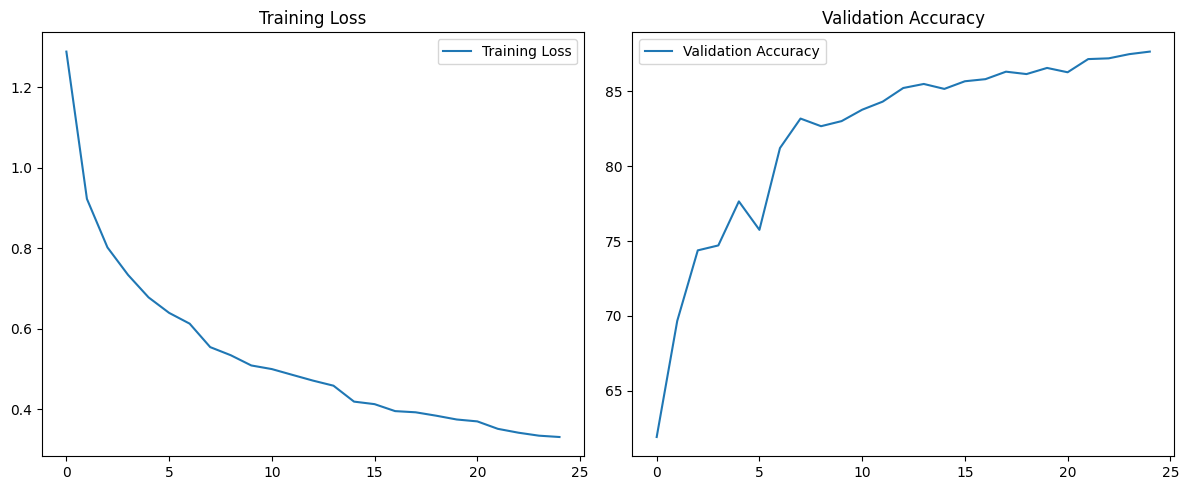

Accuracy of plane: 90.80%
Accuracy of car  : 94.30%
Accuracy of bird : 78.40%
Accuracy of cat  : 74.60%
Accuracy of deer : 88.80%
Accuracy of dog  : 78.90%
Accuracy of frog : 94.70%
Accuracy of horse: 90.00%
Accuracy of ship : 94.10%
Accuracy of truck: 90.70%


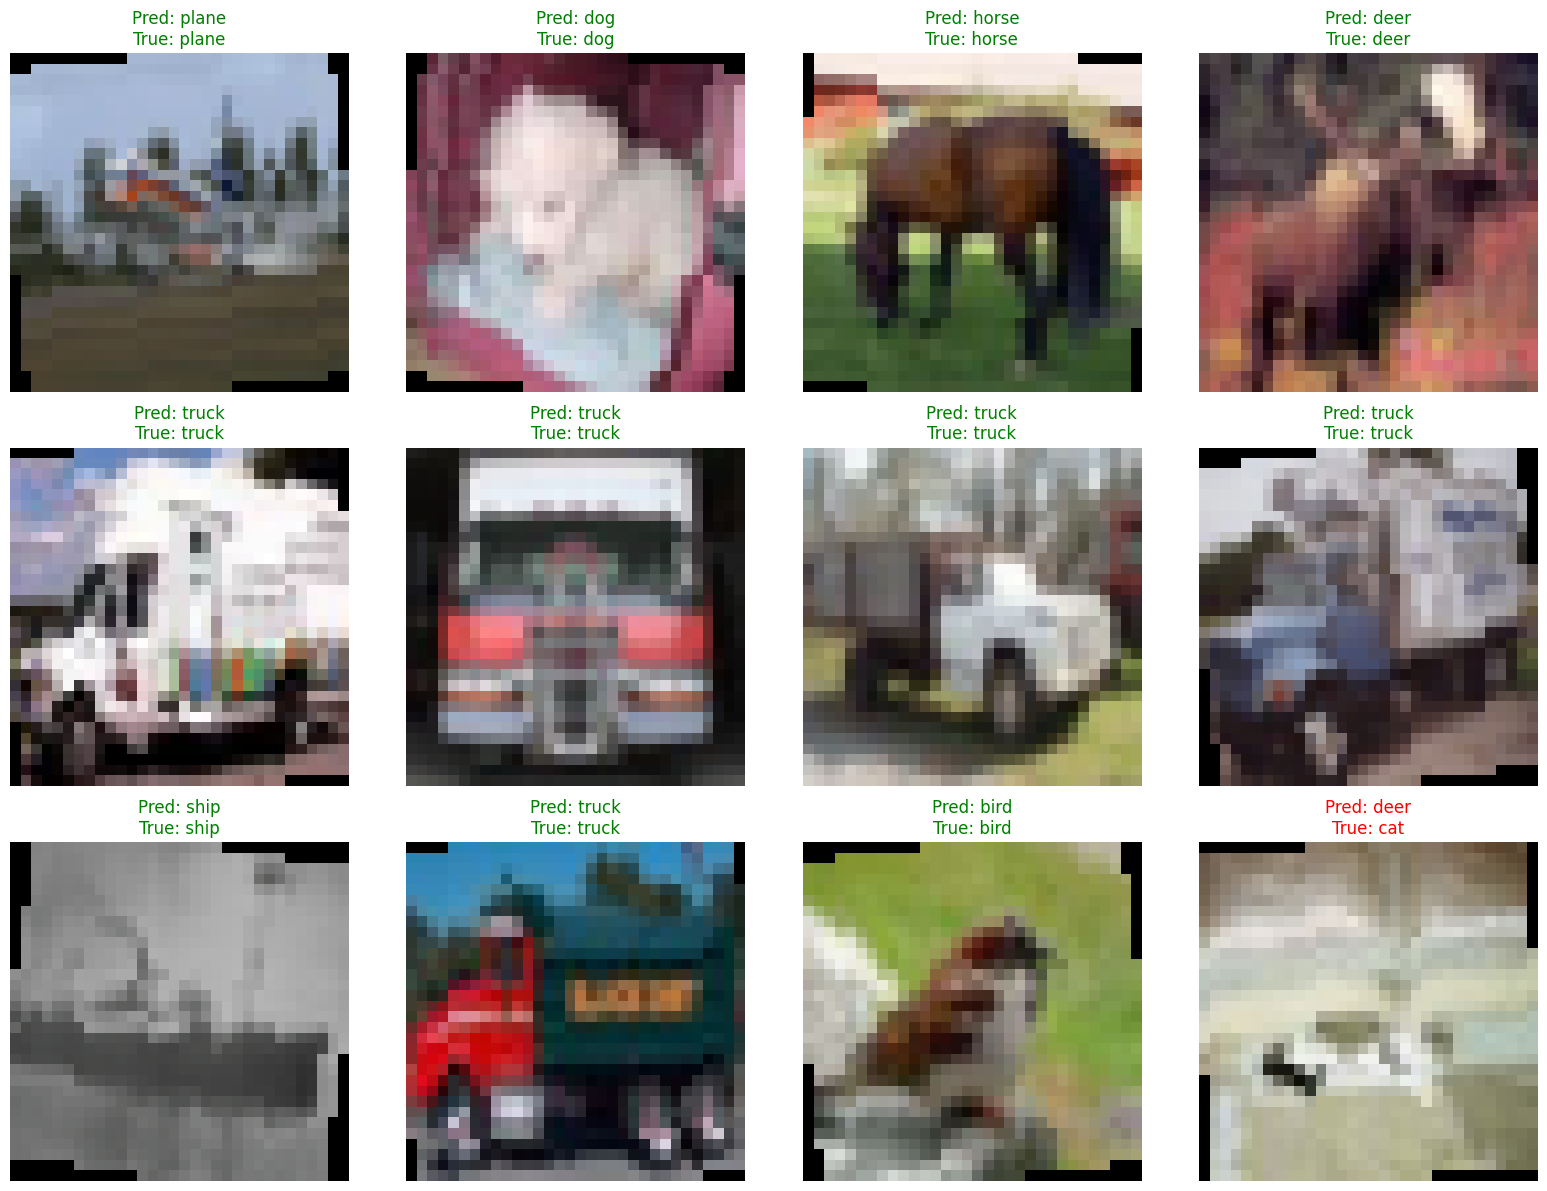

In [11]:
# Визуализация 
def plot_results():
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_results()

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_cifar_model.pth'))

# Точность по классам
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predicted):
            class_correct[label] += (prediction == label).item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s}: {100 * class_correct[i]/class_total[i]:.2f}%')

# Визуализация 
def visualize_predictions(num_images=12):
    model.eval()
    indices = np.random.choice(len(testset), num_images, replace=False)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    for idx, ax in zip(indices, axes.flat):
        image, label = testset[idx]
        img = image.numpy().transpose((1, 2, 0))
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            prediction = torch.argmax(output).item()
        
        ax.imshow(img)
        ax.set_title(f'Pred: {classes[prediction]}\nTrue: {classes[label]}', color=('green' if prediction == label else 'red'))
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions()